In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import interact

from ipywidgets import widgets
from tqdm.auto import tqdm

from vol.vol import Heston

from hestonmc import MarketState, HestonParameters, mc_price, simulate_heston_euler, simulate_heston_andersen_qe, simulate_heston_andersen_tg, european_call_payoff

## Tests

In [79]:
heston_params = HestonParameters(kappa = 1.3125, gamma = 0.5125, rho = -0.3937, vbar = 0.0641, v0 = 0.3) #from stoch vol
#heston_params = HestonParameters(kappa = 1, gamma = 0.4, rho = -0.1, vbar = 0.2, v0 = 0.2) # from school
#heston_params = HestonParameters(kappa = 0.5, gamma = 1, rho = -0.9, vbar = 0.04, v0 = 0.04) #  from andeson paper 1  tg dead
#heston_params = HestonParameters(kappa = 0.3, gamma = 0.9, rho = -0.5, vbar = 0.04, v0 = 0.04) #  from andeson paper 2 
 
state         = MarketState(stock_price = 100., interest_rate = 0.)
model         = Heston(state.stock_price, heston_params.v0, heston_params.kappa, heston_params.vbar, heston_params.gamma, heston_params.rho, state.interest_rate)

r_x           = np.load(r"Data/anderson tg/r_x.npy")[0:400000]
f_nu_y        = np.load(r"Data/anderson tg/f_nu_y.npy")[0:400000]
f_sigma_y     = np.load(r"Data/anderson tg/f_sigma_y.npy")[0:400000]
kwargs        = {'x_grid' : r_x, 'f_nu_grid' : f_nu_y, 'f_sigma_grid' : f_sigma_y }

In [80]:
heston_params.gamma**2/(2*heston_params.kappa*heston_params.vbar)

1.560991011069014

### At the money

In [81]:
strike = 100.
T = 1
ec_payoff = european_call_payoff(T, strike, state.interest_rate)

common_mc_params = {"absolute_error": 5e-2, "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": True}

In [82]:
model.call_price(T, strike)

16.69960076395676

In [83]:
mc_price(N_T = 50, simulate = simulate_heston_euler,batch_size=5_000, **common_mc_params)

Random seed:                42
Number of simulate calls:   531
MAX_ITER:                   100000
Number of paths:            5310000
Absolute error:             0.05
Length of the conf intl:    0.0499857823012533
Confidence level:           0.05



16.635423748120566

In [84]:
mc_price(N_T = 50, simulate = simulate_heston_andersen_qe, batch_size=5_000, **common_mc_params)

Random seed:                42
Number of simulate calls:   525
MAX_ITER:                   100000
Number of paths:            5250000
Absolute error:             0.05
Length of the conf intl:    0.049998101668629155
Confidence level:           0.05



16.66047091678521

In [85]:
mc_price(N_T = 50, simulate = simulate_heston_andersen_tg, batch_size=5_000, **common_mc_params, **kwargs)

Random seed:                42
Number of simulate calls:   526
MAX_ITER:                   100000
Number of paths:            5260000
Absolute error:             0.05
Length of the conf intl:    0.04998560792611509
Confidence level:           0.05



16.695037807375236

Optimal batch_size for each scheme

In [17]:
common_mc_params = {"absolute_error": 5e-2,  "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": False}
for scheme in [[simulate_heston_euler, 100], [simulate_heston_andersen_qe, 50], [simulate_heston_andersen_tg, 50]]:
    print(scheme[0].__name__)
    for batch_size in range(1_000, 16_000, 1_000):
        print(f"Batch size: {batch_size}")
        if scheme[0] == simulate_heston_andersen_tg:
            %timeit -r10 mc_price(N_T = scheme[1], simulate = scheme[0], batch_size=batch_size, **common_mc_params, **kwargs)
        else:
            %timeit -r10 mc_price(N_T = scheme[1], simulate = scheme[0], batch_size=batch_size, **common_mc_params)

    print("\n\n")

simulate_heston_euler
Batch size: 1000
2.29 s ± 20 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 2000
1.96 s ± 20.9 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 3000
1.86 s ± 14.1 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 4000
1.83 s ± 38.1 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 5000
1.85 s ± 40.2 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 6000
1.85 s ± 31.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 7000
2 s ± 22.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 8000
2.15 s ± 26.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 9000
2.25 s ± 30.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 10000
2.36 s ± 28.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 11000
2.5 s ± 68.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Batch size: 12000
2.5 s ± 18.2 ms pe

In [6]:
import pandas as pd

In [19]:
MC_compare_models = pd.DataFrame(columns=['scheme' , 'N_dt',  'result'])

In [20]:
common_mc_params = {"absolute_error": 5e-2,  "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": False}
i = 0
for scheme in [simulate_heston_euler, simulate_heston_andersen_qe, simulate_heston_andersen_tg]:
    for N_dt in range(4, 132, 4):
        for _ in range(150):
            if scheme == simulate_heston_andersen_tg:
                MC_compare_models.loc[i] = (scheme.__name__, N_dt, mc_price(N_T = N_dt, simulate = scheme, batch_size=5000, **common_mc_params, **kwargs))
            else:
                MC_compare_models.loc[i] = (scheme.__name__, N_dt, mc_price(N_T = N_dt, simulate = scheme, batch_size=5000, **common_mc_params))
            i +=1

In [41]:
MC_compare_models = pd.read_csv(r"Data/evaluation/MC_compare_models.csv")

In [56]:
tmp = MC_compare_models.groupby(['scheme', 'N_dt'] ).agg([np.mean, np.std])['result']

<AxesSubplot:title={'center':'MC_compare_models'}, xlabel='scheme,N_dt'>

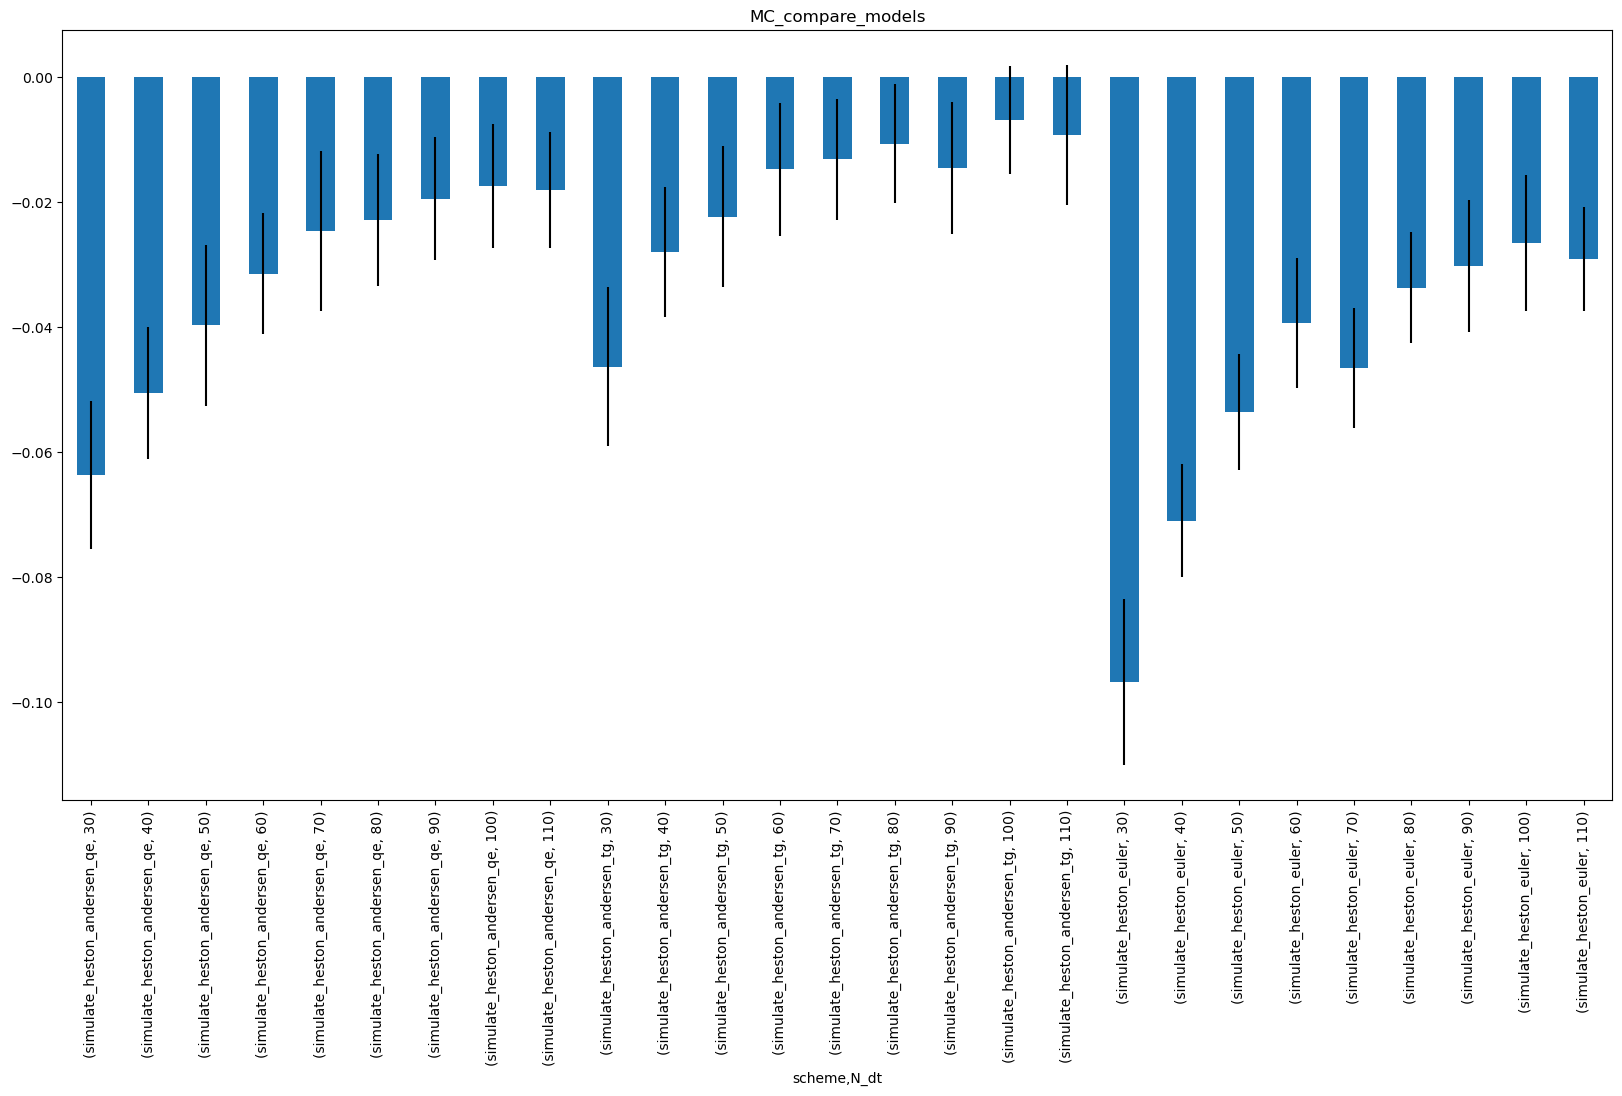

In [57]:
tmp['mean'] = tmp['mean'] - model.call_price(T, strike)
tmp['mean'].plot(kind='bar', yerr=tmp['std'], figsize=(20,10), title='MC_compare_models')

In [21]:
MC_compare_models.to_csv('MC_compare_models.csv')

In [113]:
MC_compare_models_grid = pd.DataFrame(columns=['scheme' , 'strike', 'T', 'true' ,   'mean', 'std'])

In [115]:

num_per_point = 2
i = 0
for scheme in [simulate_heston_euler, simulate_heston_andersen_qe, simulate_heston_andersen_tg]:
    for strike in np.linspace(80, 120, 10):
        for T in np.linspace(0.1, 1, 10):
            T = float(T/10)
            res = []
            ec_payoff = european_call_payoff(T, strike, state.interest_rate)
            common_mc_params = {"absolute_error": 5e-2, "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": False}
            for _ in range(num_per_point):

                if scheme == simulate_heston_andersen_tg:
                    res.append(mc_price(N_T = 50, simulate = scheme, batch_size=5000, **common_mc_params, **kwargs))
                elif scheme == simulate_heston_euler:
                    res.append(mc_price(N_T = 100, simulate = scheme, batch_size=5000, **common_mc_params))
                elif scheme == simulate_heston_andersen_qe:
                    res.append(mc_price(N_T = 50, simulate = scheme, batch_size=5000, **common_mc_params))
            MC_compare_models_grid.loc[i] = (scheme.__name__, strike, T, model.call_price(T, strike), np.mean(res), np.std(res))
            i +=1

In [141]:
MC_compare_models_grid.to_csv('MC_compare_models_grid.csv')

In [7]:
MC_compare_models_grid = pd.read_csv('MC_compare_models_grid.csv')

In [25]:
MC_compare_models_grid[MC_compare_models_grid['scheme'] == 'simulate_heston_euler'][['strike', 'T', 'mean']].pivot(index='strike', columns='T', values='mean')

T,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
strike,,,,,,,,,,
85,16.468112,18.174956,19.532771,20.625552,21.550519,22.332203,22.995971,23.566372,24.089111,24.545769
90,12.650948,14.723351,16.272476,17.479529,18.475317,19.311487,20.019792,20.630731,21.182393,21.658118
95,9.355494,11.713190,13.389183,14.677016,15.724589,16.607905,17.325401,17.982222,18.551199,19.052880
100,6.667335,9.134282,10.859212,12.190673,13.268413,14.169324,14.929257,15.581933,16.165246,16.673012
105,4.549369,7.001336,8.725293,10.045786,11.132874,12.023971,12.775523,13.443150,14.031471,14.530141
110,2.992315,5.262253,6.916464,8.198667,9.267407,10.141301,10.895954,11.536549,12.127461,12.630638
115,1.907261,3.882004,5.407551,6.649103,7.644796,8.509682,9.244054,9.884885,10.454079,10.939673


In [27]:
#3d plot the results for the euler scheme
import plotly.graph_objects as go
import plotly.express as px

"""x= np.linspace(0.1, 1.1, 0.1)
y= np.linspace(85, 120, 5)"""
fig = go.Figure(data=[go.Surface(z=MC_compare_models_grid[MC_compare_models_grid['scheme'] == 'simulate_heston_euler'][['strike', 'T', 'mean']].pivot(index='strike', columns='T', values='mean'))])
fig.show()

Time for each scheme

In [10]:
common_mc_params = {"absolute_error": 5e-2, "batch_size": 100_000, "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": False}
for scheme in [[simulate_heston_euler, 100], [simulate_heston_andersen_qe, 50], [simulate_heston_andersen_tg, 50]]:
    print(scheme[0].__name__)
    if scheme[0] == simulate_heston_andersen_tg:
        %timeit -r10 mc_price(N_T = scheme[1], simulate = scheme[0], **common_mc_params, **kwargs)
    else:
        %timeit -r10 mc_price(N_T = scheme[1], simulate = scheme[0], **common_mc_params)

    print("\n\n")

simulate_heston_euler
2.58 s ± 40.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)



simulate_heston_andersen_qe
1.61 s ± 19.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)



simulate_heston_andersen_tg
1.54 s ± 23.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)





### Out of the money

In [16]:
strike = 150.
T = 1.
ec_payoff = european_call_payoff(T, strike, state.interest_rate)

common_mc_params = {"absolute_error": 5e-2, "batch_size": 100_000, "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": True}

In [17]:
model.call_price(T, strike)

3.8269329620593098

In [21]:
mc_price(N_T = 100, simulate = simulate_heston_euler, **common_mc_params)

Random seed:                42
Number of simulate calls:   8
MAX_ITER:                   100000
Number of paths:            1600000
Absolute error:             0.05
Length of the conf intl:    0.048713328793415354
Confidence level:           0.05



3.808440229304017

In [22]:
mc_price(N_T = 50, simulate = simulate_heston_andersen_qe, **common_mc_params)

Random seed:                42
Number of simulate calls:   8
MAX_ITER:                   100000
Number of paths:            1600000
Absolute error:             0.05
Length of the conf intl:    0.04786871825864369
Confidence level:           0.05



3.7360704907842637

In [23]:
mc_price(N_T = 50, simulate = simulate_heston_andersen_tg, **common_mc_params, **kwargs)

Random seed:                42
Number of simulate calls:   8
MAX_ITER:                   100000
Number of paths:            1600000
Absolute error:             0.05
Length of the conf intl:    0.04763448353439617
Confidence level:           0.05



3.7084234167949424

In [27]:
import pandas as pd
MC_compare_models_Out_of_the_money = pd.DataFrame(columns=['scheme' , 'N_dt',  'result'])

In [28]:
common_mc_params = {"absolute_error": 5e-2,  "state": state, "heston_params": heston_params, "payoff": ec_payoff, "T": T, "random_seed": 42, "verbose": False}
i = MC_compare_models_Out_of_the_money.shape[0]
for scheme in [simulate_heston_euler, simulate_heston_andersen_qe, simulate_heston_andersen_tg]:
    for N_dt in range(4, 132, 4):
        for _ in range(5):
            if scheme == simulate_heston_andersen_tg:
                MC_compare_models_Out_of_the_money.loc[i] = (scheme.__name__, N_dt, mc_price(N_T = N_dt, simulate = scheme, batch_size=5000, **common_mc_params, **kwargs))
            else:
                MC_compare_models_Out_of_the_money.loc[i] = (scheme.__name__, N_dt, mc_price(N_T = N_dt, simulate = scheme, batch_size=5000, **common_mc_params))
            i +=1

SystemError: CPUDispatcher(<function simulate_heston_euler at 0x000001FF6AAFF550>) returned a result with an error set